# Entendimento do Problema

Objetivo do Problema:
- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.
    - Porque?
    - Qual tipo de modelo de negócio do Airbnb?
        - Marketplace (Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta (pessoas oferecendo acomodacao)
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio
            
        - Demanda (pessoas procurando acomodacao)
            - Numero de Usuários
            - LTV (Lifetime Value)
            - CAC (Client Acquisition Cost)
            
            
           Gross Revenue = (Fee*Numero cliente) - CAC 

- Proposta da Solucao
- Modelo de Predivao do primeiro destino de um novo usario.
- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
    - Input: usuario e suas caracteristicas
    - Output: usuario e suas caracteristicas com a **predicao do destino**

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt
from scipy import stats as ss

from keras import models as ml
from keras import layers as l

from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from imblearn import combine as c

##  0.1. Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

##  0.2. Carregando dados

In [3]:
df_raw = pd.read_csv('../dados/train_users_2.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [4]:
df_sessions = pd.read_csv('../dados/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0. Descrição dos Dados

In [5]:
df1 = df_raw.copy()

## 1.1. Dimensão dos Dados

In [6]:
print('Usuários Número de Linhas: {}'.format(df1.shape[0]))
print('Usuários Número de Colunas: {}'.format(df1.shape[1]))

Usuários Número de Linhas: 213451
Usuários Número de Colunas: 16


In [7]:
print('Usuários Número de Linhas: {}'.format(df_sessions.shape[0]))
print('Usuários Número de Colunas: {}'.format(df_sessions.shape[1]))

Usuários Número de Linhas: 10567737
Usuários Número de Colunas: 6


##  1.2. Tipo Dados

In [8]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check NA

In [10]:
df1.isna().sum() / len(df1) * 100

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

In [11]:
df_sessions.isna().sum() / len(df_sessions) * 100

user_id           0.326428
action            0.753482
action_type      10.657003
action_detail    10.657003
device_type       0.000000
secs_elapsed      1.287229
dtype: float64

In [12]:
# Dataset Usuário

# date_first_booking_max
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

In [13]:
# Dataset Sessions
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [14]:
df1.isna().sum() / len(df1) * 100

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [15]:
df_sessions.isna().sum() / len(df_sessions) * 100

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.4. Mudando dTyepes

In [16]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [17]:
 # date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

## 1.5. Valida Balanceamento

In [18]:
df1['country_destination'].value_counts(normalize=True) * 100

NDF      44.727486
US       39.186699
other     6.124629
FR        2.991781
IT        1.642258
GB        1.433511
ES        1.373985
CA        0.867608
DE        0.685769
NL        0.485176
AU        0.353077
PT        0.128021
Name: country_destination, dtype: float64

## 1.6. Análise descritiva

In [19]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

In [20]:
def get_analise_descritiva(df):
    d0 = df.describe()
    d1 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d2 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T
    d3 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    ct = pd.concat([d0, d3, d1, d2]).T.reset_index()
    ct.columns = ['Atributos', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'skew', 'kurtosis']
    return ct

### 1.6.1. Númerico - Users

In [21]:
get_analise_descritiva(num_attributes)

,Atributos,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,age,122636.0,37.405591,13.939900,16.0,28.0,34.0,43.0,115.0,99.0,2.089718,6.516468
1,signup_flow,122636.0,2.519513,6.604723,0.0,0.0,0.0,0.0,25.0,25.0,2.705871,5.928298


### 1.6.2. Númerico - Sessions

In [22]:
get_analise_descritiva(num_attributes_sessions)

,Atributos,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,secs_elapsed,9213930.0,19961.8251,88849.39327,0.0,333.0,1369.0,9796.0,1799977.0,1799977.0,11.137761,154.84312


### 1.6.3. Categórico - Users

In [23]:
cat_attributes.drop('id', axis=1).describe() 

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4. Categórico - Sessions

In [24]:
cat_attributes_sessions.drop('user_id', axis=1).describe() 

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [25]:
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len (cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot: >

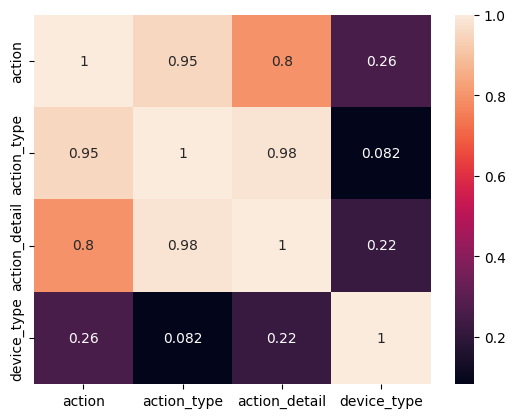

In [26]:
tmp = pd.DataFrame(corr_dict)
tmp = tmp.set_index(tmp.columns)
sns.heatmap(tmp, annot=True)

# 2.0. Feature Engineering

In [27]:
df2 = df1.copy()
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


## 2.1. Criando Novas Features

In [28]:
# dias desde o primeiro ativo até a primeira reserva
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_frist_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# dias desde a primeira ativação até a conta criada
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# dias desde a criação da conta até a primeira reserva
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# ================== Primeira Ativação ==================
df2['year_first_active'] = df2['first_active'].dt.year
df2['month_fist_active'] = df2['first_active'].dt.month
df2['day_first_active'] = df2['first_active'].dt.day
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek
df2['week_of_year_first_active'] = df2['first_active'].dt.isocalendar().week

# # ================== Primeira reserva ==================
df2['year_first_booking'] = df2['date_first_booking'].dt.year
df2['month_first_booking'] = df2['date_first_booking'].dt.month
df2['day_first_booking'] = df2['date_first_booking'].dt.day
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.isocalendar().week

# # ================== Conta Criada =================
df2['year_account_created'] = df2['date_account_created'].dt.year
df2['month_account_created'] = df2['date_account_created'].dt.month
df2['day_account_created'] = df2['date_account_created'].dt.day
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek
df2['week_of_year_account_created'] = df2['date_account_created'].dt.isocalendar().week

In [29]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,2010,2,18,3,7,2010,9,14,1,37
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,...,2010,1,5,1,1,2010,1,2,5,53


# 3.0. Filtragem Dados

In [30]:
df3 = df2.copy()

## 3.1. Filtragem Linhas

In [31]:
# Filtrando Idade maior que 15 e menor que 120 anos.
df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

## 3.2. Seleção Colunas

In [32]:
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active']
df3 = df3.drop(cols, axis=1)

# 4.0. Preparação Dados

In [33]:
df4 = df3.copy()

## 4.1. Balanceamento Dataset

In [34]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# Categorical
col_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['id', 'country_destination'], axis=1 ).columns.tolist()

# encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[ col_cat] ).toarray(), index=df4.index )

# join numerical and categorical
df42 = pd.concat( [df4[col_num], df4_dummy], axis=1 )
df42.shape

(122636, 391)

### 4.1.1. Random Undersampling

In [35]:
 # ratio_balanced
ratio_balanced = {'NDF': 10000 }
# define sampler
undersampling = us.RandomUnderSampler( sampling_strategy=ratio_balanced, random_state=32 )

# apply sampler
X_under, y_under = undersampling.fit_resample( df42, df4['country_destination'] )

e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [36]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [37]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

### 4.1.2. Random Oversampling

In [38]:
# ratio_balanced
#ratio_balanced = {'NDF': 10000 }

# define sampler
oversampling = oversamp.RandomOverSampler( sampling_strategy='all', random_state=32 )

# apply sampler
X_over, y_over = oversampling.fit_resample( df42, df4['country_destination'] )

e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [39]:
df4['country_destination'].value_counts() 

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [40]:
y_over.value_counts() 

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

### 4.1.3. SMOTE + TOMEKLINK

In [41]:
ratio_balanced =  {'NDF': 54852,
                'US':  48057,
                'other': 6*7511,
                'FR': 12*3669,
                'IT': 20*2014,
                'GB': 30*1758,
                'ES': 30*1685,
                'CA': 40*1064,
                'DE': 45*841,
                'NL': 80*595,
                'AU': 85*433,
                'PT': 300*157}

In [42]:
## - Como é muito demorado para executar, salvo em arquivo para depois carregar já com SmoteTomek

# # define sampler
# smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# # apply sampler
# X_smt, y_smt = smt.fit_resample( df42, df4['country_destination'] )

# X_smt.to_csv('../dados/X_SMOTETomek')
# y_smt.to_csv('../dados/y_SMOTETomek')

e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [46]:
df4['country_destination'].value_counts() 

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [47]:
y_smt.value_counts() 

NDF      54850
GB       52729
ES       50537
US       47891
NL       47598
PT       47100
other    44945
FR       43992
CA       42556
IT       40265
DE       37841
AU       36805
Name: country_destination, dtype: int64

In [49]:
# numerical data
df43 = X_smt[ col_num ]

# categorical data
df44 = X_smt.drop( col_num, axis=1 )
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index )

# join numerical categorical
df46 = pd.concat( [df43, df45], axis=1 )
df46['country_destination'] = y_smt

## --Dummy variável alvo

In [53]:
df46.head()

,signup_flow,days_from_frist_active_until_booking,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,year_first_active,month_fist_active,day_first_active,day_of_week_first_active,year_first_booking,month_first_booking,...,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,week_of_year_first_active,week_of_year_first_booking,week_of_year_account_created,country_destination
0,0,2228,732,1496,2009,5,23,5,2015,6,...,seo,google,untracked,Web,Mac Desktop,Chrome,21,27,21,NDF
1,3,419,476,-57,2009,6,9,1,2010,8,...,direct,direct,untracked,Web,Windows Desktop,IE,24,31,39,US
2,0,1043,765,278,2009,10,31,5,2012,9,...,direct,direct,untracked,Web,Mac Desktop,Firefox,44,36,49,other
3,0,72,280,-208,2009,12,8,1,2010,2,...,direct,direct,untracked,Web,Mac Desktop,Chrome,50,7,37,US
4,0,3,0,3,2010,1,2,5,2010,1,...,other,craigslist,untracked,Web,Mac Desktop,Safari,53,1,53,US


In [54]:
# Padrão
# df4_dummy = pd.get_dummies(df4.drop(['id', 'country_destination'], axis=1))
# df4 = pd.concat([df4[['id', 'country_destination']], df4_dummy], axis=1)

df4_dummy = pd.get_dummies(df46.drop(['country_destination'], axis=1))
df4 = pd.concat([df4[['country_destination']], df4_dummy], axis=1) 

C:\Users\laurivan\AppData\Local\Temp\ipykernel_1040\3333518680.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df4_dummy = pd.get_dummies(df46.drop(['country_destination'], axis=1))


# 5.0. Seleção Features

In [56]:
# Remove datas originais pois é inútil para o modelo.
# cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active']
# df5 = df4.drop(cols_drop, axis=1)

df5 = df4.copy()

In [57]:
X = df5.drop('country_destination', axis=1)
y = df5['country_destination'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

# 6.0. Machine Learning

In [59]:
# x_train = X_train.drop('id', axis=1)
# x_test = X_test.drop('id', axis=1)

x_train = X_train
x_test = X_test

## 6.1. Baseline 

In [60]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list,  
                             weights=country_destination_weights,
                             k=k_num)
len(yhat_random)

109422

### 6.1.1 Baseline Performance

In [61]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy:{}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12))

ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

## 6.2. Neural Network MLP

In [63]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

# Definição Modelo
model = ml.Sequential()
model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Treino
model.fit(x_train, y_train_nn, epochs=100, verbose=True)

Epoch 1/100
13678/13678 [==============================] - 51s 4ms/step - loss: 2.6210 - accuracy: 0.7087
Epoch 2/100
13678/13678 [==============================] - 38s 3ms/step - loss: 0.8094 - accuracy: 0.7740
Epoch 3/100
13678/13678 [==============================] - 40s 3ms/step - loss: 0.8013 - accuracy: 0.7738
Epoch 4/100
13678/13678 [==============================] - 38s 3ms/step - loss: 0.8013 - accuracy: 0.7749
Epoch 5/100
13678/13678 [==============================] - 38s 3ms/step - loss: 0.7965 - accuracy: 0.7741
Epoch 6/100
13678/13678 [==============================] - 38s 3ms/step - loss: 0.7926 - accuracy: 0.7759
Epoch 7/100
13678/13678 [==============================] - 39s 3ms/step - loss: 0.7922 - accuracy: 0.7759
Epoch 8/100
13678/13678 [==============================] - 38s 3ms/step - loss: 0.7911 - accuracy: 0.7759
Epoch 9/100
13678/13678 [==============================] - 41s 3ms/step - loss: 0.7906 - accuracy: 0.7759
Epoch 10/100
13678/13678 [====================

### 6.2.1 NN Performance

In [64]:
# Predição
pred_nn = model.predict(x_test)

# Inverte predição
yhat_nn = ohe.inverse_transform(pred_nn)

y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

3420/3420 [==============================] - 4s 1ms/step


In [65]:
# Acurácia
acc_nn =m.accuracy_score(y_test_nn, yhat_nn)
print(f'Acurácia: {acc_nn}')

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy:{}'.format(balanced_acc_nn))

# Kappa
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Matriz de Confusão
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

# Acurácia: 0.8412426614481409
# Balanced Accuracy:0.16665800325744187
# Kappa Score: 0.7273389222364827

ValueError: unknown is not supported

Acurácia: 0.7094976164283096

Balanced Accuracy:0.09153183873284591

Kappa Score: 0.004007337133695277

### 6.2.1 NN Performance - Cross-Validation

In [ ]:
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print(f'Fold {i}/{num_folds}')

    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # Definição Modelo
    model = ml.Sequential()
    model.add(l.Dense(512, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Treino modelo
    model.fit(x_train_fold, y_train_fold_nn, epochs=50, batch_size=32, verbose=0)

    # Predição
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # Ajusta os dados com reshape
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]

    # Métricas
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1   


Fold 1/5


KeyboardInterrupt: 

In [ ]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list), 2), 
                                                  np.round(np.std(balanced_acc_list), 4)))
print('Avg Kappa: {} +/- {}'.format(np.round(np.mean(kappa_acc_list), 4), 
                                      np.round(np.std(kappa_acc_list), 4)))

Avg Balanced Accuracy: 0.11 +/- 0.0008
Avg Kappa: 0.1859 +/- 0.0068


Avg Balanced Accuracy: 0.09 +/- 0.0003

Avg Kappa: 0.003 +/- 0.0018